<center><img src="http://mdst.eecs.umich.edu/images/mdst-logo-circle.png" width=350></center>

# Introduction to Decision Trees

Decision trees make excellent classifiers.  They are able to capture more complicated structure than linear models and a trained decision tree has an easy interpretation.

A decision tree makes predictions by partitioning the input space, or the space that our data lives in, into regions and then assigning a label to each region.

How does the decision tree decide where to split?  And how does it know which dimension to split on first?  These decisions will be determined by the mathematical formulation of the model, and we will omit them here.  If you are interested in learning more, see <a href="https://en.wikipedia.org/wiki/Decision_tree_learning">this wikipedia article</a>.  To specifically learn about how decision trees split the input space into regions, read the section titled "Metrics."

That said, let's take a look at using these things.

In [7]:
# We begin by importing numpy and pandas, as usual.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We'll be evaluating our models as well.
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve

In [2]:
train_df = pd.read_csv('./data/flint_train.csv')
test_df = pd.read_csv('./data/flint_test.csv')
train_df.head()

,sample_id,Lead_(ppb),parcel_id,Date_Submitted,google_add,Latitude,Longitude,Owner_Type,Land_Value,Land_Improvements_Value,...,Ward,PRECINCT,CENTRACT,CENBLOCK,SL_Type,SL_Type2,SL_Lead,Homestead,Homestead_Percent,HomeSEV
0,sample_012585,0.0,parcel_000036,2015-09-25 11:07:30,"1930 Colchester Rd, Flint, MI 48503, USA",42.994119,-83.723837,Private,20173,0,...,8,50,003600,6,1,0,0,Yes,100.0,35000
1,sample_006656,0.0,parcel_000036,2016-02-12 13:05:05,"1930 Colchester Rd, Flint, MI 48503, USA",42.994119,-83.723837,Private,20173,0,...,8,50,003600,6,1,0,0,Yes,100.0,35000
2,sample_007366,0.0,parcel_004160,2015-09-30 13:06:52,"605 Garland St, Flint, MI 48503, USA",43.020701,-83.696796,Private,15089,85227,...,5,32,002800,2,1,0,0,No,0.0,0
3,sample_014024,4.0,parcel_004160,2015-09-30 13:06:51,"605 Garland St, Flint, MI 48503, USA",43.020701,-83.696796,Private,15089,85227,...,5,32,002800,2,1,0,0,No,0.0,0
4,sample_003639,0.0,parcel_010786,2015-09-30 13:07:02,"4307 Ogema Ave, Flint, MI 48507, USA",42.984745,-83.660663,Private,7526,0,...,9,61,003500,3,1,0,0,Yes,100.0,0


Last time we had some trouble when our training sets and test sets didn't quite "line up."  In the below cell we prevent any problems by combining all of our data together before transforming it using get_dummies.

In [3]:
dummy_columns = ['Owner_Type', 'Residential_Building_Style', 'USPS_Vacancy', 
                 'Building_Storeys', 'Rental', 'Use_Type', 'Prop_Class', 'Zoning', 'Future_Landuse', 'DRAFT_Zone',
                 'Housing_Condition_2012', 'Housing_Condition_2014','Hydrant_Type', 'Ward', 'PRECINCT', 'CENTRACT', 
                 'Commercial_Condition_2013','CENBLOCK', 'SL_Type', 'SL_Type2', 'SL_Lead', 'Homestead']

drop_columns = ['sample_id', 'google_add', 'parcel_id', 'Date_Submitted']

combined_df = train_df.append(test_df)

combined_df = combined_df.drop(drop_columns, axis=1)
combined_df = pd.get_dummies(combined_df, columns = dummy_columns)

train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

# The combining of the dataframes created an empty column for lead in test_df.  We drop it here.
test_df = test_df.drop('Lead_(ppb)', axis=1)

#train_df = train_df.drop(drop_columns, axis=1)
#train_df = pd.get_dummies(train_df, columns=dummy_columns)

What follows should be starting to look like old news if you have been coming to the tutorials.  Split the training data into a training set and a test set.  We will use these sets to experiment and see which models are better.

In [22]:
from sklearn.cross_validation import train_test_split

Ydata_r = train_df['Lead_(ppb)']
Ydata_c = train_df['Lead_(ppb)'] > 15
Xdata = train_df.drop('Lead_(ppb)', axis=1)

# We'll be starting with a regression problem, so split on Ydata_r

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata_c)

There are several different classifiers in sklearn that depend on decision trees.  We will start with the simplest one, a single tree classifier.  These become the building blocks of more complicated models.

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(Xtrain, Ytrain)
yhat1 = dt.predict_proba(Xtest)

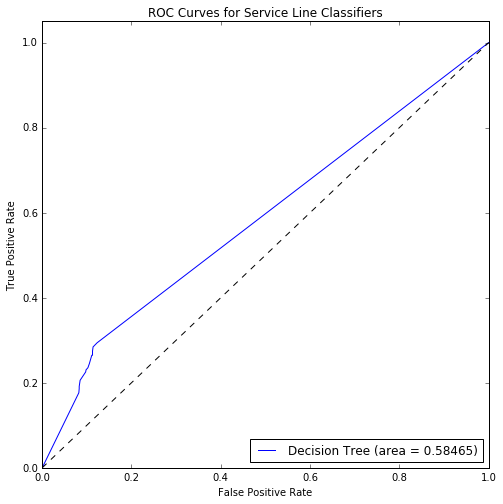

In [9]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat1[:,1])
plt.plot(fpr, tpr, label= 'Decision Tree (area = %0.5f)' % roc(Ytest, yhat1[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

Random forest classifiers are excellent.  They are cheap to run, they are parallelizable, and the produce very good results.  They are a good go-to first classifier when you get a new data set.

Random forests are collections of decision trees.  Each tree learns on a different subset of the columns in the data space.  Once all the trees are learned, the model combines the predictions into a better classifer.  How????

Suppose that we had 4 models that were independent of each other.  The models make a correct prediction with the following probabilities:

<pre>

|       | Probability Correct | Probability Incorrect |
|-------|---------------------|-----------------------|
|Model 1|       0.70          |         0.30          |
|Model 2|       0.65          |         0.35          |
|Model 3|       0.60          |         0.40          |
|Model 4|       0.55          |         0.45          |
|-------|---------------------|-----------------------|

</pre>

What is the probability that Model 1 makes an incorrect prediction an

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(Xtrain, Ytrain)
yhat2 = rf.predict_proba(Xtest)

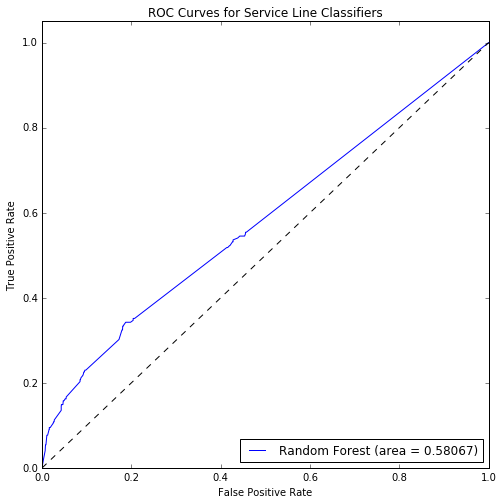

In [24]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat2[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat2[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

ExtraTreesClassifier is like a random forest, only EXTRA RANDOM!  This model is called an extremely randomized trees model.  This model acts like a random forest, except instead of training the individual decision trees the usual way by  trying to split the input space optimally it splits the input space randomly.  Hence "Extremely Random"

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier()
et.fit(Xtrain, Ytrain)
yhat3 = et.predict_proba(Xtest)

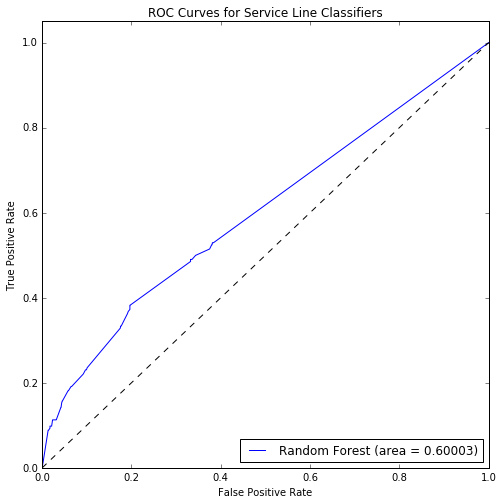

In [16]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat3[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat3[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# Now let's make a submission together.
# The logistic regression model was probably best, so we'll use that.

yhat = lr.predict_proba(test_df)

# The predict_proba method produces an N x 2 vector that has the probability of
# label 0 in the first columna and the probability of label 1 in the second column.
# The submission asks for the probability of 1, we we pull that out.

pred = yhat[:,1]

# Finally, the submission asks for the sample ids of the predictions.  We'll get
# those now and then create the submission data frame.

sample_ids = pd.read_csv('./data/flint_test.csv', usecols=['sample_id'])

submission_df = pd.DataFrame({'sample_id':sample_ids['sample_id'], 'Lead_gt_15':pred})
submission_df.to_csv('./data/submission.csv', index=False)